This Colab Notebook is loosely inspired by:
https://colab.sandbox.google.com/github/titu1994/tf-eager-examples/blob/master/notebooks/02_logistic_regression.ipynb#scrollTo=EExxt0J1kfLK

It covers:

* Enabling Eager-Mode in Colab/Jupyter notebooks (where cells can be re-run).
* Using TensorFlow's interface to "[Keras](https://en.wikipedia.org/wiki/Keras)" with TF-Eager to set up and train 
   a moderate-quality handwritten digit classifier.
* Doing batch-generation and training with low-level Python rather than higher-level TensorFlow APIs.
* Using trainable models as building blocks of larger trainable models.
* Building custom loss-functions.
* Using tf.einsum() to good advantage.
* "Inverting" a model to find an input that produces a given output.



We start with setting up TensorFlow globally for Eager-Mode execution. We do this as the very first thing in this notebook.

In [0]:
from __future__ import absolute_import, division, print_function
import numpy
import tensorflow as tf

print('TF Version:', tf.__version__)

# Enabling eager mode for tensorflow.
# This check makes running this cell (and hence enabling tf-eager) idempotent.
try:
  tf.enable_eager_execution()
  print('TF-Eager mode is enabled.')
except ValueError as exn:
  if tf.executing_eagerly():
    print('TF-Eager mode already was enabled.')
  elif 'must be called at program startup' in exn.args[0]:
    print ('Eager-Mode must be enabled at start-time.\n'
           'Please Restart the Runtime '
           '([Runtime] -> [Restart Runtime] or Ctrl-M).')
  else:
    # Unknown situation, re-raise exception.
    raise



We need some other libraries, and also need to do a bit of set-up.

In [0]:
import numpy
import os
import pprint

from matplotlib import pyplot

from tensorflow.contrib.eager.python import tfe
from tensorflow.python.keras.datasets import mnist

try:  # Python2/3 compatibility hack.
  xrange(1)
except NameError:  # Python3 does not have xrange().
  xrange = range

# Seed the numpy and tensorflow random number generators to make this Colab
# Notebook more reproducible. This generally helps for debugging, and in
# particular also helps when resolving why-am-I-seeing-this student questions
# that partially depend on chance.
tf.set_random_seed(0)
numpy.random.seed(0)

Next, we load our Machine-Learning Dataset, tens of thousands of labeled handwritten digits from MNIST.
Let us also see how some examples actually look like.

In [0]:
# Documentation on this dataset: 
# https://keras.io/datasets/#mnist-database-of-handwritten-digits
(x_train_uint8, y_train_uint8), (x_test_uint8, y_test) = mnist.load_data()
x_train = x_train_uint8.astype(numpy.float32) / 255.0
x_test = x_test_uint8.astype(numpy.float32) / 255.0
y_train = y_train_uint8.astype(numpy.int32)

# Let us visualize some of the training-digits.
for n in xrange(10):
  axes = pyplot.subplot(2, 5, n + 1)
  axes.matshow(x_train[n])
  axes.grid(False)

Now, let us set up and train a basic handwritten digit classifier. This implementation shows how this looks like generically, but is (deliberately) not at the state-of-the-art for this problem set.

For this example, we do want a classifier that is not quite "perfect", since we want to study improving the performance of a somewhat weak model built on top of it.

In [0]:
# We define a basic MNIST-classifier model, along the lines of:
# https://www.tensorflow.org/guide/eager#train_a_model

# This network architecture is not the best choice for this task, but just
# an example for how such a network may look like generically. Also,
# there are many different ways to set up a trainable deep net. Implementing
# a subclass of tf.keras.Model (like here) is just one of them. Our model is
# simple enough to make tf.keras.Sequential() a more attractive option.
# One may - for example - also use more low-level operations to directly work
# with explicit trainable weights- and biases-tensors.
class MNISTModel(tf.keras.Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(
        units=120,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(0.003))
    self.dense2 = tf.keras.layers.Dense(
        units=40,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(0.003))
    self.dense3 = tf.keras.layers.Dense(units=10) 

  def call(self, input):
    """Runs the model (overridden method)."""
    activations1 = self.dense1(input)
    activations2 = self.dense2(activations1)
    return self.dense3(activations2)

# Get a model-object. This has random-initialized weights.
mnist_model = MNISTModel()
print('MNIST Model Object:', mnist_model)

# We can apply this model straightaway - if we synthesize a batch with
# just one example. The model will return a [num_examples, 10]-tensor
# which, for each batch-example gives us a logit (think: linearly 
# additive evidence) for the input to represent the digit '0', the digit '1',
# etc.
debug_batch0 = tf.constant(x_train[0].reshape((1, 28**2)))
debug_eval0 = mnist_model(debug_batch0)
# Logits are perhaps not as telling as probabilities, so we map logits
# to actual probabilities with tf.nn.softmax(). As the model's initial weights
# are essentially random, we expect these probabilities to be very roughly
# similar, and not meaningful.
print('Example Model Evaluation:', tf.nn.softmax(debug_eval0))

For a basic handwritten digit classifier, the simplest interesting figure of merit is its accuracy: What is the percentage of correctly classified digits, for digits that the model has not seen in its training?

In [0]:
# We define a function that allows us to measure performance of a MNIST 
# model classifier on the test-set.
#
# We do this in an ad-hoc way here, relying on TF-Eager being mostly a wrapping
# layer around numpy. For later, we add the ability to only measure this on
# some stride of the test-set. This is a simple way to split the test-set into
# a validation-set and an actual test-set-for-final-evaluation.
def mnist_model_test_set_accuracy(model, offset=0, skip=1):
  """Computes the accuracy of a MNIST-model on the test set."""
  predicted_logits = model(
      tf.constant(x_test.reshape(-1, 28**2)[offset::skip, :])).numpy()
  predicted_digits = numpy.argmax(predicted_logits, axis=1)
  return numpy.average(predicted_digits == y_test[offset::skip])


# The initial model is basically just guessing random answers, so we expect it
# to be correct roughly 10% of the time.
print('Initial MNIST model accuracy:',
      mnist_model_test_set_accuracy(mnist_model))

Let us train this model in a rather pedestrian way, that is, using only low-level TensorFlow, not higher level APIs.

In [0]:
# Training the model. This roughly follows:
# https://www.tensorflow.org/guide/eager#train_a_model
# There are more high-level ways to do model-training with TensorFlow.
# In this tutorial, we tend to mix lower-level and higher-level TensorFlow
# functions/methods, to demonstrate how one can do things in different ways.

LEARNING_RATE = 1e-4
NUM_EPOCHS = 20  # Sufficient for a basic demo. 40 is better.
BATCH_SIZE = 128

def mnist_loss(model, x, y):
  prediction = model(x)
  with tf.device("/cpu:0"):  # Device placement example (TF can do this for us).
   ret = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=prediction)
  return ret


def mnist_grad(model, inputs, targets):
  tape = tf.GradientTape()
  with tape:
    loss_value = mnist_loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)


mnist_optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)


# We do all the batching manually here.
for num_epoch in xrange(NUM_EPOCHS):
  # For better reproducibility, we use a random number generator seeded with
  # the number of the epoch.
  rng = numpy.random.RandomState(seed=num_epoch)
  permutation = numpy.array(range(len(x_train)))
  rng.shuffle(permutation)
  x_train_perm = x_train[permutation]
  y_train_perm = y_train[permutation]
  #
  num_batch = 0
  while (1 + num_batch) * BATCH_SIZE < len(x_train):
    batch_slice = slice(num_batch * BATCH_SIZE, (1 + num_batch) * BATCH_SIZE)
    x_train_batch = tf.constant(
        x_train_perm[batch_slice, :, :].reshape(BATCH_SIZE, 28**2))
    y_train_batch = tf.constant(
        y_train_perm[batch_slice].reshape(BATCH_SIZE))
    gradient = mnist_grad(mnist_model, x_train_batch, y_train_batch)
    mnist_optimizer.apply_gradients(zip(gradient, mnist_model.variables))
    if num_batch % 200 == 0:
      print("E={:04d}/{:04d}: Loss={:.6g}, Accuracy(Validation-Set)={:.2f}%"
            .format(num_epoch, num_batch,
                    mnist_loss(mnist_model, x_train_batch, y_train_batch),
                    100 * mnist_model_test_set_accuracy(mnist_model,
                                                        offset=1, skip=2)))
    num_batch += 1
    
print('Done Training. Test-Set Accuracy: {:.2f}%'.format(
    100 * mnist_model_test_set_accuracy(mnist_model, offset=0, skip=2)))

We now should have a trained model with about 96-98% accuracy, which for this problem is actually pretty low for current standards. Still, this is just right to get a somewhat poor multi-digit classifier which we then want to improve using methods covered in this workshop. Let us plot some predictions to see if they make sense.

In [0]:
# Plotting some example predictions.
for n in xrange(12):
  axes = pyplot.subplot(2, 6, n + 1)
  predicted_logits = mnist_model(
      tf.constant(x_test[n].reshape((1, 28**2)))).numpy().reshape((10,))
  predicted_number = numpy.argmax(predicted_logits)
  axes.matshow(x_test[n])
  axes.set_title('T={}, P={}'.format(y_test[n], predicted_number),
                 y=0, color='b')
  axes.grid(False)
  
model_logits_testset = mnist_model(x_test.reshape((len(x_test), 28**2)))
model_predictions = numpy.argmax(model_logits_testset.numpy().reshape((-1, 10)),
                                 axis=1)
print('Predictions:', model_predictions[:12], '...')
print('Truth:      ', y_test[:12], '...')
accuracy = numpy.average([prediction == groundtruth
                          for prediction, groundtruth in zip(model_predictions,
                                                            y_test)])
print('Accuracy: {:7.2f}%'.format(accuracy * 100))
        

Let us now consider a variant of this problem: We want to scan handwritten account numbers. For simplicity, we assume that each digit has been written into its own box, which has been digitized independently, and there are only four digits in total.

Let us also assume that these 4-digit account-numbers actually come with a built-in checksum: All valid account numbers are divisible by 9. Having this extra knowledge should somehow be exploitable by ML, so if a handwritten account number could be read as either '2519' or '2619', the model should be able to have learned that '2519' cannot be a correct interpretation.

If the probabilities to recognize each single digit correctly were independent, then a single-digit success rate of 96% would mean that the odds of recognizing a 4-digit number correctly is 0.96^4, i.e. about 85%. However, this is not what we would expect in reality, since the difficulty to recognize digits written by the same person is not uncorrelated. For people with very clear handwriting, we would expect to easily recognize just about every 4-digit number they write, while for people with bad handwriting, we would expect a high probability to have two or more barely-recognizable digits in the number.

There are many different ways for designing the architecture of such a ML model. Here, we want to do it as follows:


*   While we have to recognize four digits, we want these four sub-problems to use the same trainable parameters, so we in effect only train one handwritten-digit-recognizer.
*   For each of the 4 digits, we get a 10-dimensional vector of logits (think: accumulated evidence) for the digit to be a 0, 1, 2, etc. We explicitly map these to probabilities.
*   We want to have two contributions to the overall loss-function: Cross-entropy loss on the predicted digits as before, plus some extra loss that depends on whether the 4-digit number as it was read is divisible by 9.
*   We expect that most problems come from single-digit errors, such as mis-reading a '5' as a '6' in '5112'. While we could try to design a network that could in principle figure out that it needs to have another very close look at the pixel data to determine whether the '2' is really a '2' or rather a '3', or alternatively the '5' is really a '5' or rather a '6' in the number '2510', we want to consider this as beyond our scope. Rather, we want something that only tweaks the predicted likelihoods for the 1st digit to be a 0, a 1, a 2, etc. according to what the other digits likely are - and correspondingly for the 2nd digit, etc.
*  Strictly speaking, we should have a logit for each possible output-number from '0000' to '9999'. Nevertheless, we use an architecture where we always make the crude assumption that the probability for a given number is the product of the probabilities for all the digits, and the 'divisible-by-9' constraint is implemented as adjustments to single-digit probabilities found by looking at the probability-distribution for all the digits.
*   So, after we obtained the 4x10 logits for the likelihoods for the thousands, hundreds, tens, and ones to be a particular digit, we want to have some other layer(s) that predict corrections to these logits. In training this correction-predicting part, we add a loss that punishes predicting numbers not divisible by 9.

This approach may be neither the smartest nor the simplest thing to do for such a problem. The simplest approach likely would be to pick the 4-digit number with highest predicted likelihood that is also divisible by 9. Still, we want to do this as sketched above, because this will give us a good tour of a number of useful techniques.



Let us first implement a component that tells us, for four 10-vectors of logits, the probability for the final number to be divisible by 9. We keep this very low-level to demonstrate how to mix higher-level concepts like Keras models or layers with low-level TensorFlow.

In [0]:
# We use an auxiliary tensor constant which, for two digits, tells us the mod-9
# remainder of their sum.
# It is generally not helpful to think of a rank-3 tensor like this as some
# sort of 'three-dimensional matrix' (even more so for ranks beyond 3).
# Tensors like this are better interpreted as some sort of SQL-like table,
# which in this particular case would roughly look as follows (listing only
# non-zero entries):
#
# Summand1Mod9,     Summand2Mod9,      SumMod9, Multiplier
# 0,                0,                 0,       1
# 0,                1,                 1,       1
# 0,                2,                 2,       1
# (...)
# 1,                0,                 1,       1
# 1,                1,                 2,       1
# (...)
# 2,                4,                 6,       1
# (...)
# 5,                7,                 3,       1
# (...)
mod9sum = numpy.zeros([10, 10, 10], dtype=numpy.float32)
for n1 in xrange(10):
  for n2 in xrange(10):
    mod9sum[n1, n2, (n1 + n2) % 9] = 1.0

# The corresponding tensor-constant:
tc_mod9sum = tf.constant(mod9sum)

# Index 'b' is the batch-example index. Number of batch-examples is 'B'.
def get_prob_for_being_multiple_of_9(logit_by_digit_and_place):
  # The parameter 'logit_by_digit_and_place' is a (B, 10, 4)-tensor.
  # Entry [b, 7, 0] is the predicted logit-space evidence for the 4-digit
  # number to have a '7' in the 'thousands' place, for example 'b'.
  # Entry [9, 1] is the predicted logit-space evidence for the 4-digit
  # number to have a '9' in the 'hundreds' place, for example 'b'.
  #
  # We first map logits to probabilities with softmax().
  probability_by_digit_and_place = tf.nn.softmax(logit_by_digit_and_place)
  # Index-names correspond to roman-numeral place-values.
  #
  #
  # Here and below: We use latin-inspired index-names M, C, X, I for thousands,
  # hundreds, tens, and ones. The 'tf.einsum()' tensor-product can be read as an 
  # equivalent SQL statement roughly of the form:
  #
  # select M.NumExample, M.Digit, C.Digit, M.Value * C.Value
  # from ExamplesThousands as M, ExamplesHundreds as C
  # where M.NumExample = C.NumExample;
  #
  # (B, 10, 10)-tensor.
  # Entry [b, 2, 3] is the probability for the number to be of the form 23xx.  
  prob_digits12 = tf.einsum('bM,bC->bMC',
                            probability_by_digit_and_place[:, 0],
                            probability_by_digit_and_place[:, 1])
  # (B, 10)-tensor.
  # Entry [b, 7] is the probability for the sum-mod-9 of the first 2 digits
  # to be 7.
  mod9prob_digits12 = tf.einsum('MCr,bMC->br', tc_mod9sum, prob_digits12)
  # Likewise: Digits 3 and 4.
  prob_digits34 = tf.einsum('bX,bI->bXI',
                            probability_by_digit_and_place[:, 2],
                            probability_by_digit_and_place[:, 3])
  mod9prob_digits34 = tf.einsum('XIs,bXI->bs', tc_mod9sum, prob_digits34)
  # (B, 10, 10)-tensor. Entry [b, 4, 7] is the probability for the first
  # two digits to have mod-9 sum 4 and the last two digits to have mod-9 sum 7.
  mod9prob_digits12_34 = tf.einsum('br,bs->brs',
                                   mod9prob_digits12,
                                   mod9prob_digits34)
  # (B, 10)-tensor. Entry [b, 5] is the probability for the number to have
  # mod-9 digit-sum 5.
  # TASK: Simplify the code so that we only compute entry 0.
  mod9prob_all = tf.einsum('rst,brs->bt', tc_mod9sum, mod9prob_digits12_34)
  # Return probability for mod-9 sum to be 0 (for all batch-examples).
  return mod9prob_all[:, 0]




This plausibility check shows what this function does. Note that due to TF-Eager, we can work with TF-tensors pretty much as if they were numpy arrays.

In [0]:
# Some artificial logits that correspond to a 4-digit number that most likely
# would read as '0008'.
t_ddd_ex = tf.constant(numpy.array([
    [ 9.0, -1.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [ 9.0, -1.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [ 9.0, -1.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [-1.0,  -1.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, 9.0, -1.0]],
    dtype=numpy.float32))

print('Probability',
      get_prob_for_being_multiple_of_9(tf.reshape(t_ddd_ex, (1, 4, 10))))

# EXERCISE: Add another example with a logit-distribution that corresponds to
# likely seeing a number that is divisible by 9.

# SOLUTION: (There are many options here.)
t_ddd_ex1809 = tf.constant(numpy.array([
    [-1.0, 20.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [ -5.0, -1.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, 20.0, -1.0],
    [ 9.0, -1.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [-1.0,  -1.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, 50.0]],
    dtype=numpy.float32))
print('Probability for a number likely reading as 1809:',
      get_prob_for_being_multiple_of_9(tf.reshape(t_ddd_ex1809, (1, 4, 10)))
      .numpy()[0])


Next, let us build a simple ML model for reading a 4-digit account number. The basic idea is that we apply our single-digit recognition model to each of the four digits, but then take the logits and feed them through two extra layers that can tweak them.

In order for this to make sense, we will need to provide some criterion for what a good way to tweak the prediction looks like. Here, this criterion will be the probability for the predicted 4-digit number to be divisible by 9. This is a custom loss function for this particular design approach to the problem.

What do we expect this to achieve? In a situation where the four single-digit-recognition problems left us with e.g. "pretty sure that the first 3 digits are 2, 3, and 1, but for the last digit, there is a 50-50 chance that this is a 2 or a 3", the divisible-by-9 rule tells us that we should predict a 3 (so we can boost that logit).

Note that if we have a 96% chance to get a single digit read correctly, then running the same model on four independent digits gives us a probability of 100% * 0.96^4 = ca. 85% to get all four digits right. Our initial 4-digit model, that can apply tweaks, starts out as not being trained to apply such changes correctly, so we expect worse-than-this-baseline behavior.

In [0]:
# For the four-digit-account-number model, we allow plugging in a separately 
# trained digit-recognition model, and allow the user to specify whether
# training should tweak that model or not.

class AccountNumberModel(tf.keras.Model):
  def __init__(self, mnist_model, train_mnist_model=False):
    super(AccountNumberModel, self).__init__()
    self._mnist_model = mnist_model
    self._train_mnist_model = train_mnist_model
    # As for the MNIST-model, this architecture does not try to be
    # especially clever.
    self._dense1 = tf.keras.layers.Dense(
        units=120,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(0.03))
    # This layer is supposed to return a correction to be added to 4*10 logits,
    # so needs to have 4*10 units.
    self._dense2 = tf.keras.layers.Dense(
        units=4 * 10,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(0.03))
    

  def _apply_mnist_model(self, single_digit_input):
    # If the model was set up to allow training the contained MNIST-model.
    # we allow gradient-backpropagation to continue into the weights of
    # this sub-model. Otherwise, we stop gradient-backpropagation here.
    if self._train_mnist_model:
      return self._mnist_model(single_digit_input)
    else:
      return tf.stop_gradient(self._mnist_model(single_digit_input))
    
  def call(self, input):
    """Runs the model (overridden method)."""
    pixeldata_by_digit = tf.reshape(input, (-1, 4, 28**2))
    # (B, 4, 10)-Tensor. Entry (b, 0, 6) is the logit given by the MNIST-model
    # for the leading (thousands)-digit of the account number to be '6'.
    raw_logit_by_place_and_digit = tf.stack(
        [self._apply_mnist_model(pixeldata_by_digit[:, num_place, :])
         for num_place in (0, 1, 2, 3)], axis=1)
    d1 = self._dense1(tf.reshape(raw_logit_by_place_and_digit, (-1, 40)))
    d2 = self._dense2(d1)
    correction = tf.reshape(d2, (-1, 4, 10))
    return raw_logit_by_place_and_digit + correction 


acct_model = AccountNumberModel(mnist_model, train_mnist_model=False)


mnist_model_accuracy_before_acct_model_training = (
    mnist_model_test_set_accuracy(mnist_model, offset=0, skip=2))

print('MNIST Model Accuracy: {:.2f}% - Baseline Account-Model Accuracy: {:.2f}%'
      .format(100 * mnist_model_accuracy_before_acct_model_training,
              100 * mnist_model_accuracy_before_acct_model_training**4))


# Trying out the account-number model on 'meaningless' input data
# ('four empty boxes'), just to ensure that it can be applied.
debug_acct0 = acct_model(tf.constant(numpy.zeros([1, 4, 28**2],
                                                 dtype=numpy.float32)))
print('debug_acct0', debug_acct0)  # This shows raw logits, not probabilities.


Let us train this model. Here, we do not actually use a conventional batched training set. Rather, we keep randomly assembling fresh batches of 4-digit numbers from the MNIST examples.

In [0]:
ACCT_LEARNING_RATE = 1e-4
ACCT_BATCH_SIZE = 128
ACCT_NUM_ITERATIONS = 4000
ACCT_MOD9_LOSS_WEIGHT = 1e3


def fourdigits(ds):
  '''Helper function. Formats 4-vector of digits as digit-string.'''
  return '{}{}{}{}'.format(*ds)


def acct_loss(acct_model, x, y):
  prediction = acct_model(x)
  # This shows how to control hardware-association in TensorFlow.
  # It is actually not necessary here, since TensorFlow knows where it
  # can place tf.losses.sparse_softmax_cross_entropy() and where it can not.
  # with tf.device("/cpu:0"):
  digits_loss = tf.losses.sparse_softmax_cross_entropy(
       labels=y, logits=prediction)
  mod9_loss = 1.0 - get_prob_for_being_multiple_of_9(prediction)
  return tf.reduce_mean(digits_loss + ACCT_MOD9_LOSS_WEIGHT * mod9_loss)


def acct_grad(acct_model, inputs, targets):
  tape = tf.GradientTape()
  with tape:
    loss_value = acct_loss(acct_model, inputs, targets)
  return tape.gradient(loss_value, acct_model.variables)


acct_optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# When generating example batches of handwritten 4-digit numbers,
# the final digit is a function of the first three digits.
# We hence want to know, for each digit, what the candidates are.
candidates_by_digit = [[] for _ in xrange(10)]
for n, digit in enumerate(y_train):
  candidates_by_digit[digit].append(n)

candidate_acct_numbers = numpy.array([[x // 1000 % 10,
                                       x // 100 % 10,
                                       x // 10 % 10,
                                       x % 10] for x in xrange(0, 10000, 9)])


# Here, we do training in a more ad-hoc fashion, and randomly generate each
# batch for batch-gradient-descent by first drawing some valid account-numbers
# at random, and then finding random instances of handwritten digits.
def generate_acct_training_batch(batch_size=ACCT_BATCH_SIZE, seed=0):
  '''Synthesizes an account-model training-batch.'''
  acct_rng = numpy.random.RandomState(seed=seed)
  batch_acct_numbers = candidate_acct_numbers[
    acct_rng.randint(0, len(candidate_acct_numbers), batch_size)]
  choices = numpy.array(
      [[candidates_by_digit[d][acct_rng.randint(0, len(candidates_by_digit[d]))]
        for d in digits]
       for digits in batch_acct_numbers], dtype=int)
  raw_account_numbers = y_train[choices]
  y_train_batch = tf.constant(y_train[choices])
  x_train_batch = tf.constant(x_train[choices])
  return x_train_batch, y_train_batch


# We generate one particular batch which we hold on to. We will repeatedly
# evaluate and report performance on this particular random batch.
acct_batch0_x, acct_batch0_y = generate_acct_training_batch(batch_size=10000,
                                                            seed=10**8)

def get_acct_model_batch0_performance(model):
  '''Computes performance of an account-model on acct_batch0_(x,y).
  
  Args:
    model: an AccountNumberModel model.
    
  Returns:
    Pair of (accuracy, diffs), where `accuracy` reports the model-accuracy,
    and `diffs` is a list of triplets
    (example_index, 4-digit-string prediction, 4-digit-string target)
    listing the deviations between predictions and targets.
  '''
  predictions = numpy.argmax(model(acct_batch0_x)[:,:,:].numpy(), axis=-1)
  targets = acct_batch0_y.numpy()
  diffs = [(n, fourdigits(p), fourdigits(t))
           for n, (p, t) in enumerate(zip(predictions, targets))
           if tuple(p) != tuple(t)]
  accuracy = 1.0 - len(diffs) / float(len(targets))
  return accuracy, diffs


for num_iteration in xrange(ACCT_NUM_ITERATIONS):
  x_train_batch, y_train_batch = generate_acct_training_batch(
      seed=num_iteration)
  acct_gradient = acct_grad(acct_model, x_train_batch, y_train_batch)
  # Note that acct_model.variables will include the MNIST-model's variables,
  # if we allowed gradient-backpropagation into the MNIST model.
  acct_optimizer.apply_gradients(zip(acct_gradient, acct_model.variables))
  if num_iteration % 100 == 0:
    accuracy, diffs = get_acct_model_batch0_performance(acct_model)
    print("N={:06d}: Loss={:.6g}, Accuracy(batch0)={:.2f}%, diffs: {}".format(
          num_iteration,
          acct_loss(acct_model, x_train_batch, y_train_batch),
          100 * accuracy, diffs[:3]))

(acct_model_final_accuracy, _) = get_acct_model_batch0_performance(acct_model)
mnist_model_accuracy_after_acct_model_training = (
    mnist_model_test_set_accuracy(mnist_model, offset=0, skip=2))
print('Done Training Account-Number Model.\n\n'
      'AC-Model accuracy: {:.2f}%,\n'
      'MNIST accuracy: {:.2f}%,\n'
      'MNIST-only expected accuracy: {:.2f}'.format(
          100 * acct_model_final_accuracy,
          100 * mnist_model_accuracy_after_acct_model_training,
          100 * mnist_model_accuracy_after_acct_model_training**4))

The model which we trained showes somewhat better than baseline-performance: It is better than what we would expect from just running our MNIST-classifier independently on four randomly picked numbers.  So, the model seems to have managed to partially utilize the extra information from the checksum.  Note however, that with this design, the account-number model does actually often predict invalid account-numbers.


In [0]:
# Exercise: Evaluate Account-Number model accuracy on test-set.

# SOLUTION (mostly cut&paste).
test_candidates_by_digit = [[] for _ in xrange(10)]
for n, digit in enumerate(y_test):
  test_candidates_by_digit[digit].append(n)

# It is actually somewhat tricky here to define what a "test example" should be.
# Do we allow re-using numbers from the MNIST test-set, or should each digit
# only be used once? If there are very many digits, this should not matter much.
def generate_acct_test_batch(batch_size=ACCT_BATCH_SIZE, seed=0):
  '''Synthesizes an account-model training-batch.'''
  acct_rng = numpy.random.RandomState(seed=seed)
  batch_acct_numbers = candidate_acct_numbers[
    acct_rng.randint(0, len(candidate_acct_numbers), batch_size)]
  choices = numpy.array(
      [[test_candidates_by_digit[d][
        acct_rng.randint(0, len(test_candidates_by_digit[d]))]
        for d in digits]
       for digits in batch_acct_numbers], dtype=int)
  raw_account_numbers = y_test[choices]
  y_test_batch = tf.constant(y_test[choices])
  x_test_batch = tf.constant(x_test[choices])
  return x_test_batch, y_test_batch


acct_test_x, acct_test_y = generate_acct_test_batch(batch_size=10000,
                                                    seed=7)

def get_acct_model_test_performance(model):
  '''Computes performance of an account-model on acct_batch0_(x,y).
  
  Args:
    model: an AccountNumberModel model.
    
  Returns:
    Pair of (accuracy, diffs), where `accuracy` reports the model-accuracy,
    and `diffs` is a list of triplets
    (example_index, 4-digit-string prediction, 4-digit-string target)
    listing the deviations between predictions and targets.
  '''
  predictions = numpy.argmax(model(acct_test_x)[:,:,:].numpy(), axis=-1)
  targets = acct_test_y.numpy()
  diffs = [(n, fourdigits(p), fourdigits(t))
           for n, (p, t) in enumerate(zip(predictions, targets))
           if tuple(p) != tuple(t)]
  accuracy = 1.0 - len(diffs) / float(len(targets))
  return accuracy, diffs

(acct_model_test_accuracy, _) = get_acct_model_test_performance(acct_model)
print('AC-Model Test-Set Accuracy:', acct_model_test_accuracy)

Finally, let us see how we can use TF-Eager's gradient-tape to compute gradients. As an example application, we want to use gradient-descent to adjust an input-vector to our MNIST-model such that it gives some particular prediction: "Find me an input that gets classified as the number >> 5 <<".

In [0]:
# 'Inverting' the MNIST-Model: let us use gradient-updates to find a
# random-generic image that produces a given classification.
#
# A problem here is that pixel-values are constrained to [0..1], while
# gradient-updates may take us out of that range.
# We use the a sigmoid to fix this.
noisy_digit_pixel_logits = tf.random_normal([1, 28**2])
noisy_digit_pixels = tf.sigmoid(noisy_digit_pixel_logits)
print('DDD noisy', tf.nn.softmax(mnist_model(noisy_digit_pixels)))
                                
# Let us find something that gets classified as some specific number.
target_classification = tf.constant([7], dtype=tf.int32)

  
def invmnist_loss(model, digit_pixel_logits, target):
  prediction = model(tf.sigmoid(digit_pixel_logits))
  with tf.device("/cpu:0"):
   ret = tf.losses.sparse_softmax_cross_entropy(labels=target,
                                                logits=prediction)
  return ret


def invmnist_grad(model, inputs, targets):
  tape = tf.GradientTape()
  with tape:
    # We explicitly have to 'watch' the inputs, since the gradient-tape
    # by default only watches parameters marked as 'trainable'.
    tape.watch(inputs)
    loss_value = invmnist_loss(model, inputs, targets)
  # Here, we keep the model's parameters fixed and extract the 
  # gradient on the input.
  return tape.gradient(loss_value, inputs)


for n in range(5000):
   gradient = invmnist_grad(mnist_model,
                            noisy_digit_pixel_logits,
                            target_classification)
   noisy_digit_pixel_logits -= 0.01 * gradient  # Negative-gradient direction!
   if n % 1000 == 0:
      print('N={:4d}, L={:8.3f}: {}'.format(
          n,
          invmnist_loss(mnist_model, 
                        noisy_digit_pixel_logits, 
                        target_classification),
          ['{:.3f}'.format(x)
           for x in tf.nn.softmax(mnist_model(
               tf.sigmoid(noisy_digit_pixel_logits))).numpy().reshape(-1)]))

axes = pyplot.subplot()
axes.matshow(tf.sigmoid(noisy_digit_pixel_logits).numpy().reshape([28, 28]))

# Does this strange image really get classified as claimed?
pprint.pprint(
    zip(range(10),
        list(tf.nn.softmax(
            mnist_model(
                tf.sigmoid(noisy_digit_pixel_logits))).numpy().reshape(-1))))


In [0]:
# EXERCISE: Change the above example to produce an input that gets classified as a '7'.
# SOLUTION: We only need to change this number above:
#
# target_classification = tf.constant([5], dtype=tf.int32)
# to:
# target_classification = tf.constant([7], dtype=tf.int32)

This then typically looks as follows:

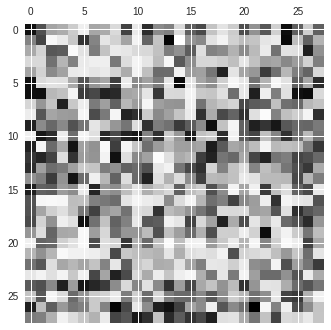

We, as humans, have a hard time recognizing anything on an image produced like this. Still, the Neural Network that we trained claims that it is more than 95% certain that the number shown on this image is a specific one.

Part of the problem may be that we trained our image-classifier so that it always has to make up its mind. Could it help if we added artificial noise to the MNIST-images, and also some noise-only images, and added an 11th category: "This is not a number, but noise?" Developing this idea further, we would then likely want to traini a network to recognize whether a digit is human-generated or some "fake" data produced by an approach like the one above. How do we get "fake" digits? We could train another network for that, and pit the fake-digit-generating network against the fake-digit-recognizer of a digit-classifier so that they co-evolve. This is roughly the idea behind Generative Adversarial Networks" .

This exploration may serve as a warning: Deep-Learning based computer vision is actually somewhat different from human vision. With ML, computers may be good (often better than humans) to mostly do the right thing, statistically speaking. But this can come with some occasional very strange behavior. Deep Learning as it is implemented in this toy example is good at finding some correlations in the input data which allow making predictions that are correct with high probability. In Engineering applications, we need to be very careful to not just make assumptions, ignoring that they may be violated in practice. Many ML applications are of the form "Let us find some mapping from many numbers (such as for example: image data) to (for example) some probability". The trained model will map any input to some output. If it only ever saw a tiny part of all theoretically possible inputs in training, we must not expect it to show desirable behavior when encountering data that is very different from training examples. Even when restricting ourselves to some kind of "plausible input subspace", such as (for example) all images that we can obtain from interpolating between known training examples, we can expect that with a bit of effort, it is possible to construct input examples where the model's behavior diverges strongly from our expectations (since the model is only doing reasonably well statistically, not necessarily for individual points - especially if we are looking for such points). Knowing to ask the right questions here is not only important for ML practitioners, but just as well for decision makers, which in democratic societies in some situations means: the population.

Exercises
*   The mod-9 scheme has some basic problems.
     Can it find all one-digit-recognition-errors? Would it help to instead
     take multiples of 11 as valid account-numbers. There is a simple rule
     to check whether a number is divisible by 11. Change the code to consider
     numbers divisible by 11 as valid account numbers.
*   Simplify the code for the MNIST model by replacing tf.keras.Model 
    with tf.Keras.Sequential.

Homework

*   Do mod-11 with and without using tf.einsum().
*   Try make the account-number model self-contained, 
     i.e. rather than referring to a MNIST-model, there should be layers for 
     digit-recognition inside it, but each of the four digit-recognition 
     sub-problems should use the same layers (and hence weights).
*   Convert from TF-Eager to non-eager tensorflow code.


In [0]:
# SOLUTIONS

# --- Mod-11 checksum ---

mod11sum = numpy.zeros([10, 10, 11],  # Note tensor shape!
                       dtype=numpy.float32)
for n1 in xrange(10):
  for n2 in xrange(10):
    mod11sum[n1, n2, (n1 + n2) % 11] = 1.0

# The corresponding tensor-constant:
tc_mod11sum = tf.constant(mod11sum)

# Index 'b' is the batch-example index. Number of batch-examples is 'B'.
def get_prob_for_being_multiple_of_11(logit_by_digit_and_place, debug=True):
  # The parameter 'logit_by_digit_and_place' is a (B, 10, 4)-tensor.
  # Entry [b, 7, 0] is the predicted logit-space evidence for the 4-digit
  # number to have a '7' in the 'thousands' place, for example 'b'.
  # Entry [9, 1] is the predicted logit-space evidence for the 4-digit
  # number to have a '9' in the 'hundreds' place, for example 'b'.
  #
  # We first map logits to probabilities with softmax().
  probability_by_digit_and_place = tf.nn.softmax(logit_by_digit_and_place)
  # Index-names correspond to roman-numeral place-values.
  #
  #
  # Here and below: We use latin-inspired index-names M, C, X, I for thousands,
  # hundreds, tens, and ones. The 'tf.einsum()' tensor-product can be read as an 
  # equivalent SQL statement roughly of the form:
  #
  # select M.NumExample, M.Digit, C.Digit, M.Value * C.Value
  # from ExamplesThousands as M, ExamplesHundreds as C
  # where M.NumExample = C.NumExample;
  #
  # (B, 10, 10)-tensor.
  # Entry [b, 2, 3] is the probability for the number to be of the form 2x3x.
  prob_digits13 = tf.einsum('bM,bC->bMC',
                            probability_by_digit_and_place[:, 0],
                            probability_by_digit_and_place[:, 2])
  # (B, 11)-tensor.
  # Entry [b, 7] is the probability for the sum-mod-11 of the Thousands and 
  # Tens-digits to be 7.
  mod11prob_digits13 = tf.einsum('MCr,bMC->br', tc_mod11sum, prob_digits13)
  if debug:
    print("DEBUG: mod11prob digits M+X", mod11prob_digits13.numpy())
  # Likewise: Digits 2 and 4.
  prob_digits24 = tf.einsum('bX,bI->bXI',
                            probability_by_digit_and_place[:, 1],
                            probability_by_digit_and_place[:, 3])
  mod11prob_digits24 = tf.einsum('XIs,bXI->bs', tc_mod11sum, prob_digits24)
  if debug:
    print("DEBUG: mod11prob digits C+I", mod11prob_digits24.numpy())
  # (B, 11, 11)-tensor. Entry [b, 4, 7] is the probability for the first
  # two digits to have mod-11 sum 4 and the last two digits to have
  # mod-11 sum 7.
  mod11prob_digits13_24 = tf.einsum('br,bs->brs',
                                     mod11prob_digits13,
                                     mod11prob_digits24)
  if debug:
    debug_probs_example0 = mod11prob_digits13_24.numpy()[0]
    for n1 in xrange(11):
      for n2 in xrange(11):
        prob_n1n2 = debug_probs_example0[n1, n2]
        if prob_n1n2 > 0.01:
          print("{:02d}, {:02d}: {:.2f}".format(n1, n2, prob_n1n2))
  # We are interested in the probability of both mod-11 sums to be equal.
  # This is a batched matrix-trace operation.
  #
  ret = tf.einsum('brr->b', mod11prob_digits13_24)  # Note.
  if debug:
    print(ret)
  return ret


# Some artificial logits that correspond to a 4-digit number that most likely
# would read as '2145'.
t_ddd_ex2145 = tf.constant(numpy.array([
    [-1.0, -1.0,  9.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [-1.0,  9.0, -1.0, -1.0, -1.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [-1.0, -1.0, -1.0, -1.0,  9.0,  -1.0, -1.0, -1.0, -1.0, -1.0],
    [-1.0, -1.0, -1.0, -1.0, -1.0,   9.0, -1.0, -1.0, -1.0, -1.0]],
    dtype=numpy.float32))

print('Probability ~2145',
      get_prob_for_being_multiple_of_11(tf.reshape(t_ddd_ex2145, (1, 4, 10))))

# --- tf.keras.Sequential model ---
mnist_model_seq = tf.keras.Sequential([
  tf.keras.layers.Dense(
        units=120,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(0.003)),
  tf.keras.layers.Dense(
        units=40,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.l2(0.003)),
  tf.keras.layers.Dense(units=10)])

debug_eval_seq0 = mnist_model_seq(debug_batch0)
# Logits are perhaps not as telling as probabilities, so we map logits
# to actual probabilities with tf.nn.softmax(). As the model's initial weights
# are essentially random, we expect these probabilities to be very roughly
# similar, and not meaningful.
print('Example Model Evaluation:', tf.nn.softmax(debug_eval_seq0))
